# 20260128: 實作NCSN+Annealing Langevin Sampling - 2D Spiral

1. 建構 NCSN (Model)：寫一個神經網路，輸入是 $(x, \sigma)$，輸出是 $\epsilon$ (或 Score)。 定義 Loss Function 來訓練它。
2. 實作 Algorithm 1 (Sampling)：寫一個函式，裡面有兩層迴圈。外層控制 $\sigma$ (Annealing)。內層跑 $T$ 次演算法中第 6 行的公式 (Langevin Step)。



---

# Model

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def get_spiral_data(n_samples):
    theta = torch.sqrt(torch.rand(n_samples)) * 6 * np.pi 
    r = theta
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)    
    data = torch.stack([x, y], dim=1)
    # 標準化到 [-1, 1] 附近
    return data / (6 * np.pi) 

# 初始化範圍建議：既然數據在 [-1, 1]，初始化可以灑在 [-1.2, 1.2]
# x_init = torch.rand(n_samples, 2) * 2.4 - 1.2

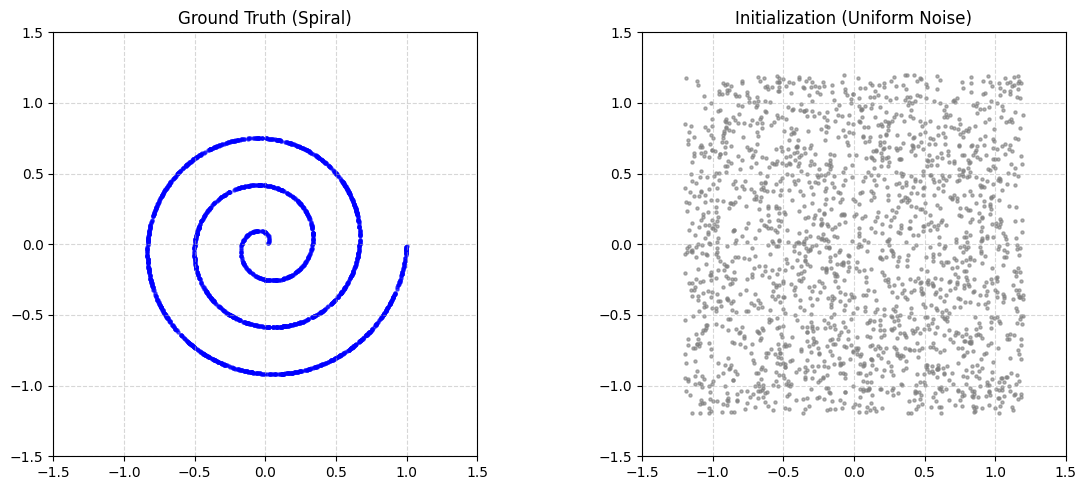

In [6]:
n_samples = 2000
ground_truth = get_spiral_data(n_samples)
x_init = torch.rand(n_samples, 2) * 2.4 - 1.2

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(ground_truth[:, 0], ground_truth[:, 1], s=5, alpha=0.6, c='blue')
plt.title("Ground Truth (Spiral)")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_aspect('equal')

# 右圖：Initialization 範圍
plt.subplot(1, 2, 2)
plt.scatter(x_init[:, 0], x_init[:, 1], s=5, alpha=0.6, c='gray')
plt.title("Initialization (Uniform Noise)")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()

In [4]:
class GaussianFourierProjection(torch.nn.Module):
    def __init__(self, embed_dim, scale=10.):
        super().__init__()
        self.W = torch.nn.Parameter(torch.randn(1, embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        # x shape: [batch, 2]
        x_proj = x @ self.W * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# Annealed Langevin Sampling